# South Africa COVID-19 projections

Inspired by "[Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)"
by Gianluca Malato.

This is a quick experiment to fit South Africa's COVID-19 case numbers to the
[logistic function](https://en.wikipedia.org/wiki/Logistic_function), to make some projections.

First, get the raw data, and extract the bits we're interested in:

In [1]:
import pandas as pd


url = 'https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/South_Africa_medical_cases'
table_title = 'COVID-19 cases in South Africa by province'

full_df: pd.DataFrame
[full_df] = pd.read_html(url, match=table_title)

In [2]:
# print(full_df.columns)

df: pd.DataFrame
df = full_df[[('Date', 'Date'), ('Confirmed', 'Total')]]

# Drop the last four (non-data) rows.
df = df[:-4]
# Make sure it's all coerced to numeric.
df[('Confirmed', 'Total')] = pd.to_numeric(df[('Confirmed', 'Total')])

print(df)

          Date Confirmed
          Date     Total
0   2020-03-04         0
1   2020-03-05         1
2   2020-03-06         1
3   2020-03-07         2
4   2020-03-08         3
5   2020-03-09         7
6   2020-03-10        10
7   2020-03-11        13
8   2020-03-12        16
9   2020-03-13        24
10  2020-03-14        38
11  2020-03-15        51
12  2020-03-16        62
13  2020-03-17        85
14  2020-03-18       116
15  2020-03-19       150
16  2020-03-20       202
17  2020-03-21       240


Define the logistic function, with some scaling parameters:

In [3]:
from scipy.special import expit


def logistic(t, rate, mid, limit):
    """
    :param t: Time (days) 
    :param rate: Growth rate constant
    :param mid: Inflection point
    :param limit: Population limit
    """
    return limit * expit(rate * (t - mid))

Curve-fit the data:

In [4]:
import numpy as np
from scipy.optimize import curve_fit


# Helper function
def estimates(xdata, ydata):
    """
    Return a set of fitted parameters.
    """
    initial_guesses = [0.3, 20, 2000]
    
    def best_fit():
        popt, pcov = curve_fit(
            logistic,
            xdata=xdata,
            ydata=ydata,
            p0=initial_guesses,
        )
        errors = np.sqrt(pcov.diagonal())
        return popt, errors

    # Like best_fit, but fix the rate.
    def rate_fit(rate):
        popt, pcov = curve_fit(
            lambda t, mid, limit: logistic(t, rate, mid, limit),
            xdata=xdata,
            ydata=ydata,
            p0=initial_guesses[1:],
        )
        return [rate] + list(popt)
    
    # Like best_fit, but fix the limit.
    def limit_fit(limit):
        popt, pcov = curve_fit(
            lambda t, rate, mid: logistic(t, rate, mid, limit),
            xdata=xdata,
            ydata=ydata,
            p0=initial_guesses[:2],
        )
        return list(popt) + [limit]

    # Best-fit parameters
    p_mid, errors = best_fit()
    
    # Low and high parameters, using the rate's variance
    rate = p_mid[0]
    rate_error = errors[0]
    p_min = rate_fit(rate + rate_error)
    p_max = rate_fit(rate - rate_error)
    
    # Parameters based on the projected infection of ⅔ of SA's population
    # (~40 million)
    p_limit = limit_fit(40e6)
    
    return p_min, p_mid, p_max, p_limit


# XXX: For now, just assume the data has no gaps, and days equal indexes.
data_days = range(len(df))
data_cases = df[('Confirmed', 'Total')]

p_min, p_mid, p_max, p_limit = estimates(data_days, data_cases)

print('Min:', *p_min, sep='\t')
print('Mid:', *p_mid, sep='\t')
print('Max:', *p_max, sep='\t')
print()
print('Limit:', *p_limit, sep='\t')

Min:	0.36314029116322993	17.40526029860752	522.1231319459611
Mid:	0.3486421212867169	17.967087799624952	582.8106937311857
Max:	0.33414395141020387	18.664970684659927	668.5115795375757

Limit:	0.270997054793355	61.207423032786124	40000000.0


Plot some data!

This is also plotted [here](https://docs.google.com/spreadsheets/d/1zJC06iokpJ65-ZdJCgqCAIgpYpUTwOlpcxI_27wTtn8/edit#gid=384217832).

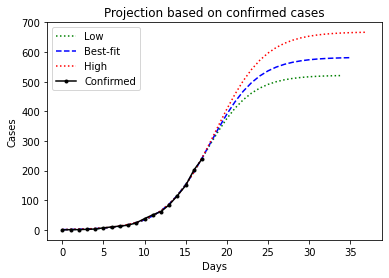

In [5]:
import matplotlib.pyplot as plt


plt.plot(logistic(range(int(np.ceil(p_min[1] * 2))), *p_min), 'g:', label='Low')
plt.plot(logistic(range(int(np.ceil(p_mid[1] * 2))), *p_mid), 'b--', label='Best-fit')
plt.plot(logistic(range(int(np.ceil(p_max[1] * 2))), *p_max), 'r:', label='High')

plt.plot(data_cases, 'k.-', label='Confirmed')

plt.title('Projection based on confirmed cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()

Fitting to ⅔ of the population? (Not a great fit.)

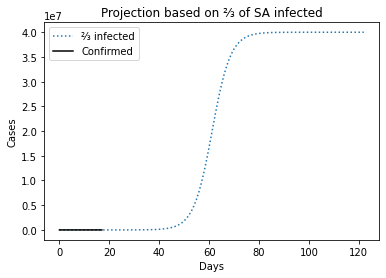

In [6]:
plt.plot(logistic(range(int(np.ceil(p_limit[1] * 2))), *p_limit), ':', label='⅔ infected')
plt.plot(data_days, data_cases, 'k-', label='Confirmed')

plt.title('Projection based on ⅔ of SA infected')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()